In [1]:
# Checking system version - Diagnostic
import sys
print(sys.version)

3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:47:18) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Supressing all warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import datetime as dt
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import talib
import copy
import time
from stocktrends import Renko
import statsmodels.api as sm

In [4]:
# Display certain rows and columns for any dataframe
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

In [5]:
# Suppress scientific notation
pd.options.display.float_format = '{:.8f}'.format

## Start

In [6]:
stocks = ["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]
start = dt.datetime.today()-dt.timedelta(3650)
end = dt.datetime.today()

# empty dataframe which will be filled with closing prices of each stock
cl_price = pd.DataFrame() 

2 ways people deal with NaN values:

Method 1 - Fill NaN values with some data

```cl_price.fillna(method='bfill',axis=0,inplace=True)```

Method 2 - Drop/Remove particular NaN values

```cl_price.dropna(axis=0,how='any')```

In [7]:
# looping over tickers and creating a dataframe with close prices
for ticker in stocks:
    cl_price[ticker] = yf.download(ticker,start,end)["Adj Close"]
    
# filling NaN values
cl_price.dropna(axis=0,how='any',inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Initial data exploration

In [8]:
cl_price

,MSFT,AAPL,META,AMZN,INTC,CSCO,VZ,IBM,QCOM,LYFT
Date,,,,,,,,,,
2019-03-29,112.70208740,45.83480453,166.69000244,89.03749847,47.28616333,47.08988190,47.39324570,108.14031982,51.46622849,78.29000092
2019-04-01,113.73411560,46.14608002,168.69999695,90.70950317,47.99941635,47.95335388,47.36118317,109.82643890,52.17013931,69.01000214
2019-04-02,113.89656830,46.81689453,174.19999695,90.69899750,47.86732483,48.22374344,46.91233826,109.59654236,52.42282104,68.97000122
2019-04-03,114.64191437,47.13781738,173.53999329,91.03500366,48.85355759,48.52029037,47.18484879,110.07937622,52.05281830,70.00000000
2019-04-04,114.05901337,47.21986389,176.02000427,90.94300079,49.24100876,48.39741516,47.28103256,109.42790985,52.21525955,72.00000000
...,...,...,...,...,...,...,...,...,...,...
2023-08-22,322.45999146,177.22999573,287.60000610,134.25000000,32.88999939,55.45999908,33.20000076,141.49000549,109.47000122,10.81000042
2023-08-23,327.00000000,181.11999512,294.23999023,135.52000427,33.97999954,55.97999954,33.18999863,143.41000366,111.16999817,10.72000027
2023-08-24,319.97000122,176.38000488,286.75000000,131.83999634,32.59000015,55.24000168,33.38000107,143.55000305,108.51000214,10.57999992


In [9]:
# Viewing summary of each columns
cl_price.describe()

,MSFT,AAPL,META,AMZN,INTC,CSCO,VZ,IBM,QCOM,LYFT
count,1112.00000000,1112.00000000,1112.00000000,1112.00000000,1112.00000000,1112.00000000,1112.00000000,1112.00000000,1112.00000000,1112.00000000
mean,230.19285979,121.35526149,233.51548580,129.17995952,43.90860950,45.91258111,45.60662147,115.60439073,113.74253959,35.68748200
std,64.42858900,42.83815597,67.52602474,31.23963018,9.50237200,5.71152962,5.43035256,12.94602438,30.97493202,17.95211921
min,112.70208740,41.97820663,88.91000366,81.81999969,24.22220612,29.76346779,31.45999908,76.02529144,50.44647598,7.98999977
25%,177.48336411,77.96452713,183.66249847,96.77137566,35.74751568,41.77940178,42.69723034,105.32541847,82.85334587,16.26500034
50%,238.71118927,131.79584503,217.40000153,126.79499817,45.63967133,46.30115128,47.57433510,116.00040054,120.38433838,37.82999992
75%,281.35528564,152.94175339,284.09000397,159.85662079,51.49671841,50.16464901,49.51535225,124.54739761,134.91836166,49.78499889
max,358.73046875,196.18507385,382.17999268,186.57049561,63.12168503,60.60367966,53.27965927,146.02000427,182.88407898,78.29000092


In [10]:
# Returns percentage change over previous value
daily_return = cl_price.pct_change()

daily_return

,MSFT,AAPL,META,AMZN,INTC,CSCO,VZ,IBM,QCOM,LYFT
Date,,,,,,,,,,
2019-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,0.00915713,0.00679125,0.01205828,0.01877866,0.01508376,0.01833668,-0.00067652,0.01559196,0.01367714,-0.11853364
2019-04-02,0.00142836,0.01453676,0.03260225,-0.00011582,-0.00275194,0.00563860,-0.00947706,-0.00209327,0.00484342,-0.00057964
2019-04-03,0.00654406,0.00685485,-0.00378877,0.00370463,0.02060347,0.00614940,0.00580893,0.00440556,-0.00705805,0.01493401
2019-04-04,-0.00508454,0.00174057,0.01429072,-0.00101063,0.00793087,-0.00253245,0.00203845,-0.00591815,0.00312070,0.02857143
...,...,...,...,...,...,...,...,...,...,...
2023-08-22,0.00180187,0.00790491,-0.00793373,-0.00319270,-0.00754375,0.00036076,0.00606063,-0.00555238,-0.01093241,-0.02612612
2023-08-23,0.01407929,0.02194888,0.02308757,0.00945999,0.03314078,0.00937614,-0.00030127,0.01356985,0.01552934,-0.00832564
2023-08-24,-0.02149847,-0.02617044,-0.02545538,-0.02715472,-0.04090640,-0.01321897,0.00572469,0.00097622,-0.02392728,-0.01305973


In [11]:
daily_return.describe()

,MSFT,AAPL,META,AMZN,INTC,CSCO,VZ,IBM,QCOM,LYFT
count,1111.00000000,1111.00000000,1111.00000000,1111.00000000,1111.00000000,1111.00000000,1111.00000000,1111.00000000,1111.00000000,1111.00000000
mean,0.00114692,0.00144925,0.00091072,0.00061697,0.00000429,0.00032834,-0.00022956,0.00041632,0.00106897,-0.00077741
std,0.01984327,0.02081030,0.02842327,0.02258835,0.02487063,0.01833354,0.01274975,0.01702778,0.02741732,0.04520607
min,-0.14739018,-0.12864691,-0.26390095,-0.14049438,-0.18041534,-0.13730352,-0.07497793,-0.12850736,-0.14945256,-0.36436493
25%,-0.00867590,-0.00847572,-0.01187646,-0.01107226,-0.01140895,-0.00794885,-0.00579034,-0.00690761,-0.01342197,-0.02391107
50%,0.00098229,0.00109693,0.00087474,0.00071110,0.00000000,0.00045103,0.00000000,0.00088600,0.00018166,-0.00184393
75%,0.01128221,0.01303948,0.01443864,0.01201076,0.01199384,0.00887007,0.00584277,0.00826252,0.01526358,0.02348588
max,0.14216890,0.11980853,0.23282400,0.13535902,0.19521298,0.13373512,0.07208645,0.11301054,0.23207390,0.28971974


In [12]:
daily_return.mean()

MSFT    0.00114692
AAPL    0.00144925
META    0.00091072
AMZN    0.00061697
INTC    0.00000429
CSCO    0.00032834
VZ     -0.00022956
IBM     0.00041632
QCOM    0.00106897
LYFT   -0.00077741
dtype: float64

In [13]:
daily_return.std()

MSFT   0.01984327
AAPL   0.02081030
META   0.02842327
AMZN   0.02258835
INTC   0.02487063
CSCO   0.01833354
VZ     0.01274975
IBM    0.01702778
QCOM   0.02741732
LYFT   0.04520607
dtype: float64

Simple moving average

In [14]:
df = daily_return.rolling(window = 10).mean()
rolling_std = daily_return.rolling(window = 10).std()
rolling_max = daily_return.rolling(window = 10).max()
rolling_sum = daily_return.rolling(window = 10).sum()

In [15]:
df

,MSFT,AAPL,META,AMZN,INTC,CSCO,VZ,IBM,QCOM,LYFT
Date,,,,,,,,,,
2019-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-22,-0.00085902,-0.00127150,-0.00817429,-0.00407531,-0.00606819,0.00449615,0.00193826,-0.00191069,-0.00716379,-0.00558662
2023-08-23,0.00172049,0.00181882,-0.00348899,-0.00163581,-0.00064103,0.00556569,0.00147829,0.00066639,-0.00468446,0.00361543
2023-08-24,-0.00064658,-0.00067476,-0.00620818,-0.00486633,-0.00589854,0.00352669,0.00110303,0.00023065,-0.00625365,-0.00384440


In [16]:
rolling_std

,MSFT,AAPL,META,AMZN,INTC,CSCO,VZ,IBM,QCOM,LYFT
Date,,,,,,,,,,
2019-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-22,0.00898689,0.00847252,0.01756063,0.01219332,0.02031641,0.01186950,0.00676488,0.00654456,0.00744115,0.04878905
2023-08-23,0.00922328,0.01070156,0.01911974,0.01221954,0.02292677,0.01176870,0.00674291,0.00709323,0.01026013,0.03590839
2023-08-24,0.01177807,0.01391485,0.02019724,0.01431647,0.02565603,0.01314547,0.00634071,0.00690602,0.01192796,0.02976052


In [17]:
rolling_max

,MSFT,AAPL,META,AMZN,INTC,CSCO,VZ,IBM,QCOM,LYFT
Date,,,,,,,,,,
2019-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-22,0.01706267,0.00939318,0.02347747,0.01560583,0.02264262,0.03342146,0.01029679,0.00615229,0.00526795,0.06153850
2023-08-23,0.01706267,0.02194888,0.02347747,0.01560583,0.03314078,0.03342146,0.01029679,0.01356985,0.01552934,0.06153850
2023-08-24,0.01706267,0.02194888,0.02347747,0.01560583,0.03314078,0.03342146,0.01029679,0.01356985,0.01552934,0.03780065


In [18]:
rolling_sum

,MSFT,AAPL,META,AMZN,INTC,CSCO,VZ,IBM,QCOM,LYFT
Date,,,,,,,,,,
2019-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-22,-0.00859024,-0.01271503,-0.08174286,-0.04075307,-0.06068193,0.04496155,0.01938256,-0.01910692,-0.07163792,-0.05586619
2023-08-23,0.01720492,0.01818818,-0.03488987,-0.01635813,-0.00641032,0.05565694,0.01478287,0.00666394,-0.04684457,0.03615426
2023-08-24,-0.00646580,-0.00674757,-0.06208175,-0.04866331,-0.05898537,0.03526686,0.01103029,0.00230648,-0.06253646,-0.03844397


Exponential moving average

In [19]:
daily_return.ewm(com = 10, min_periods = 10).mean()

,MSFT,AAPL,META,AMZN,INTC,CSCO,VZ,IBM,QCOM,LYFT
Date,,,,,,,,,,
2019-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-22,-0.00096987,-0.00216135,-0.00365804,-0.00005195,-0.00300256,0.00360734,-0.00040673,0.00052895,-0.00543524,-0.00337114
2023-08-23,0.00039824,0.00003049,-0.00122662,0.00081277,0.00028320,0.00413178,-0.00039714,0.00171448,-0.00352937,-0.00382155
2023-08-24,-0.00159237,-0.00235141,-0.00342923,-0.00172973,-0.00346131,0.00255444,0.00015939,0.00164737,-0.00538373,-0.00466138


## Basic graphical visualization

In [20]:
# Return calculation 
daily_return = cl_price.pct_change() #Creates dataframe with daily return for each stock

<Axes: title={'center': 'Stock Price evolution Portfolio'}, xlabel='Date'>

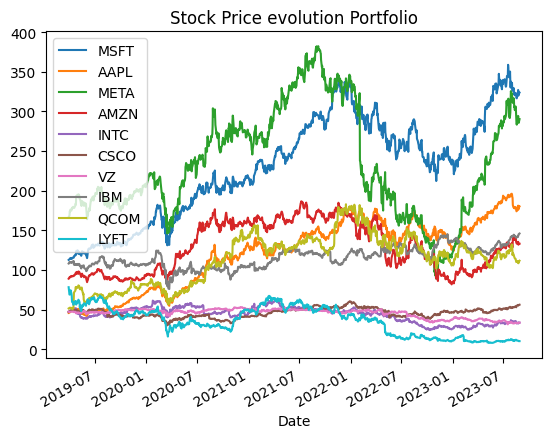

In [21]:
#plotting close prices of portfolio
cl_price.plot(title = "Stock Price evolution Portfolio") 

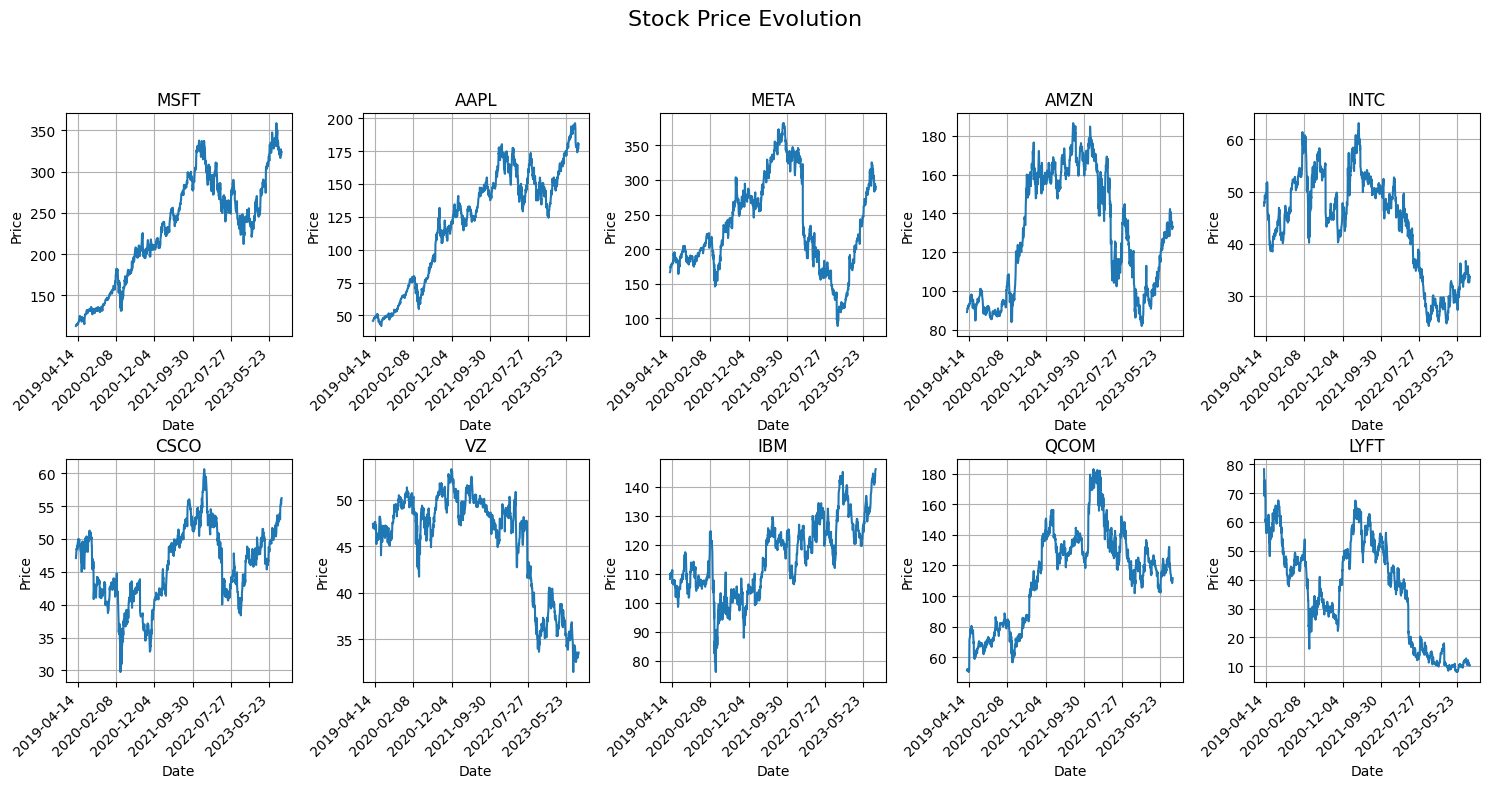

In [22]:
# Plotting Subplots of individual stocks

# Create subplots with a 2x5 layout (2 rows, 5 columns)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))  # Adjust figsize as needed
fig.suptitle("Stock Price Evolution", fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the columns of cl_price and plot each stock's price evolution
for i, column in enumerate(cl_price.columns):
    if i >= len(axes):
        break  # Break the loop after populating all available subplots

    ax = axes[i]
    cl_price[column].plot(ax=ax, title=column, grid=True)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))  # Limit number of x-axis ticks for readability

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust top spacing to make room for the title

# Show the plot
plt.show()

<Axes: title={'center': 'Daily Return Evolution Portfolio'}, xlabel='Date'>

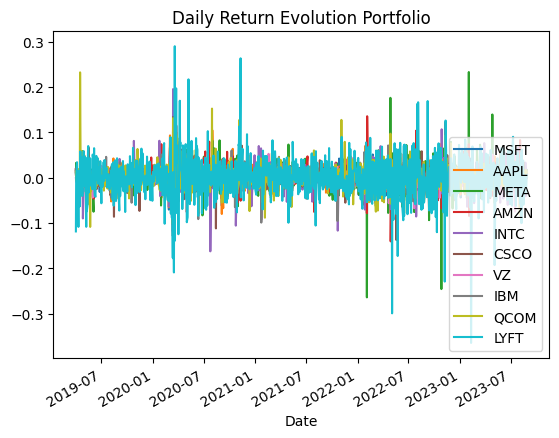

In [23]:
#plotting daily returns of portfolio
daily_return.plot(title = "Daily Return Evolution Portfolio")

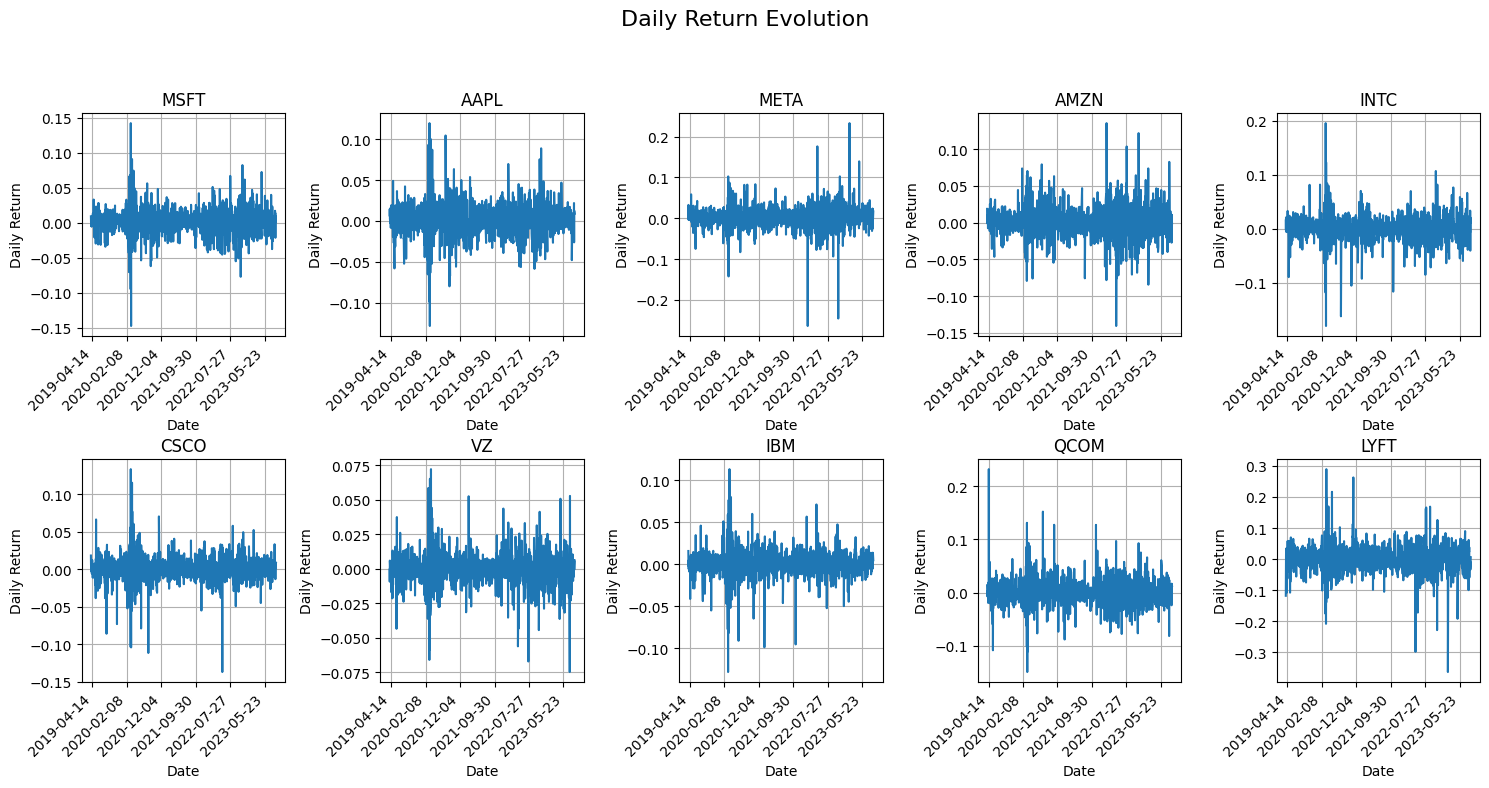

In [24]:
# Plotting daily returns of individual stocks

# Create subplots with a 2x5 layout (2 rows, 5 columns)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))  # Adjust figsize as needed
fig.suptitle("Daily Return Evolution", fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the columns of daily_return and plot each stock's daily return evolution
for i, column in enumerate(daily_return.columns):
    if i >= len(axes):
        break  # Break the loop after populating all available subplots

    ax = axes[i]
    daily_return[column].plot(ax=ax, title=column, grid=True)
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily Return")
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))  # Limit number of x-axis ticks for readability

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust top spacing to make room for the title

# Show the plot
plt.show()

<Axes: title={'center': 'Cumulative Return Portfolio'}, xlabel='Date'>

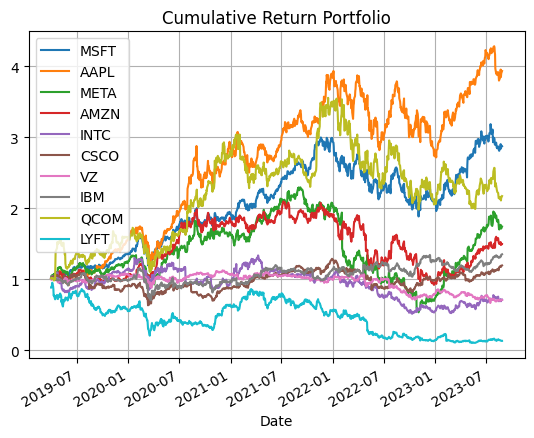

In [25]:
# Cumulative product of returns is important
(1+daily_return).cumprod().plot(title = "Cumulative Return Portfolio", grid = True)    

<BarContainer object of 10 artists>

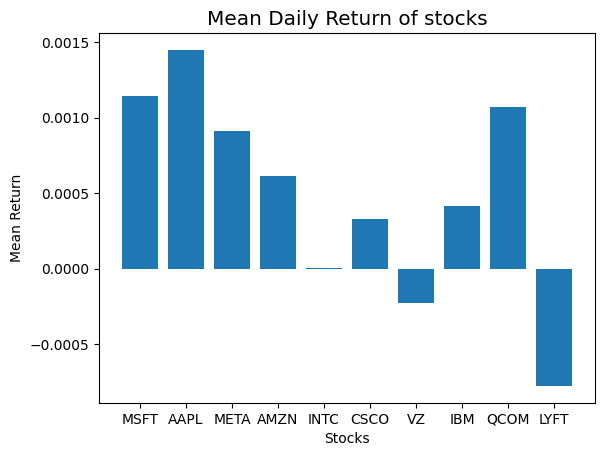

In [26]:
fig, ax = plt.subplots()

# Plotting using ggplot theme
plt.style.use("ggplot")

# Use the set function within axis object
ax.set(title = "Mean Daily Return of stocks", xlabel = "Stocks", ylabel = "Mean Return")

# Bar chart for mean daily return
plt.bar(x = daily_return.columns, height = daily_return.mean())

<BarContainer object of 10 artists>

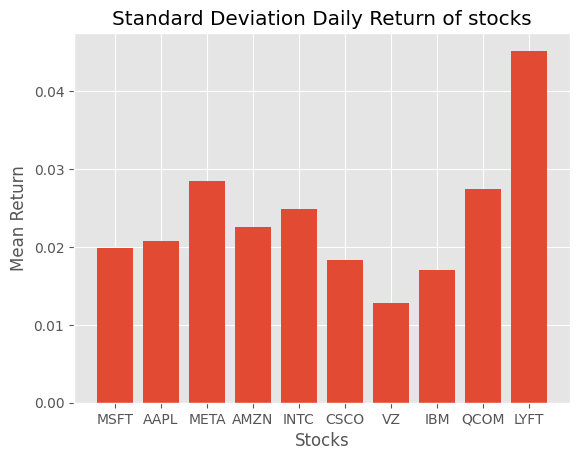

In [27]:
fig, ax = plt.subplots()

# Plotting using ggplot theme
plt.style.use("ggplot")

# Use the set function within axis object
ax.set(title = "Standard Deviation Daily Return of stocks", xlabel = "Stocks", ylabel = "Mean Return")

# Bar chart for mean daily return
plt.bar(x = daily_return.columns, height = daily_return.std())

In [28]:
# Import necesary libraries
import yfinance as yf

# Download historical data for required stocks
tickers = ["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]
ohlcv_data = {}

# looping over tickers and storing OHLCV dataframe in dictionary
for ticker in tickers:
    temp = yf.download(ticker,period='1mo',interval='5m') # Interval of 5 minutes for 1 month
    temp.dropna(how="any",inplace=True)
    ohlcv_data[ticker] = temp

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Implementing Technical Indicators

## Side note: Using TA-Lib

TA-lib library has a wide range of technical indicators that we can use easily. This is shown below for demonstration purposes.

In [29]:
import yfinance as yf
import numpy as np
import copy

# Download historical data for required stocks
tickers = ["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]
ohlcv_data = {}

# looping over tickers and storing OHLCV dataframe in dictionary
for ticker in tickers:
    temp = yf.download(ticker,period='1mo',interval='5m')
    temp.dropna(how="any",inplace=True)
    ohlcv_data[ticker] = temp

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [30]:
ohlc_dict = copy.deepcopy(ohlcv_data) #create a copy of extracted data

# Apply talib functions on each dataframe - refer documentation at https://mrjbq7.github.io/ta-lib/doc_index.html
for ticker in tickers:
    # Calculate momentum indicators (e.g. MACD, ADX, RSI etc.) using talib
    ohlc_dict[ticker]["ADX"] = talib.ADX(ohlc_dict[ticker]["High"],
                                        ohlc_dict[ticker]["Low"],
                                        ohlc_dict[ticker]["Adj Close"],
                                        timeperiod=14)
    # Identify chart patterns (e.g. two crows, three crows, three inside, engulging pattern etc.)
    ohlc_dict[ticker]["3I"] = talib.CDL3WHITESOLDIERS(ohlc_dict[ticker]["Open"],
                                                 ohlc_dict[ticker]["High"],
                                                 ohlc_dict[ticker]["Low"],
                                                 ohlc_dict[ticker]["Adj Close"])
    
    # Statistical functions (e.g. beta, correlation etc.)
    ohlc_dict[ticker]["Beta"] = talib.BETA(ohlc_dict[ticker]["High"],
                                         ohlc_dict[ticker]["Low"],
                                         timeperiod=14)

However, we lose control over the exact implementation and the lack of documentation makes it hard to understand the output.

Hence, we have implemented various technical indicators in Python below and have not used the TA-lib library.

## MACD Implementation in Python

**Trading View Calculation of MACD:**

https://www.tradingview.com/scripts/macd/?solution=43000502344

MACD Line: (12-day EMA - 26-day EMA) 

Signal Line: 9-day EMA of MACD Line

MACD Histogram: MACD Line - Signal Line

**Trading View Calculation of EMA:**
    
https://www.tradingview.com/scripts/ema/?solution=43000502589
    
1. Calculate the SMA

(Period Values / Number of Periods)

2. Calculate the Multiplier

(2 / (Number of Periods + 1) therefore (2 / (5+1) = 33.333%

3. Calculate the EMA
For the first EMA, we use the SMA(previous day) instead of EMA(previous day).

EMA = {Close - EMA(previous day)} x multiplier + EMA(previous day)

In [31]:
def MACD(DF, a=12 ,b=26, c=9):
    """function to calculate MACD
       typical values a(fast moving average) = 12; 
                      b(slow moving average) =26; 
                      c(signal line ma window) =9"""
    
    # Making a copy of the dataframe to preserve orignal data
    df = DF.copy()
    
    # Calculating fast (shorter) exponential moving average
    # Need to add min_periods for the minimum number of periods to calculate moving average
    df["ma_fast"] = df["Adj Close"].ewm(span=a, min_periods=a).mean()
    
    # Calculating slow (longer) exponential moving average
    df["ma_slow"] = df["Adj Close"].ewm(span=b, min_periods=b).mean()
    
    # Calculating macd line
    df["macd"] = df["ma_fast"] - df["ma_slow"]
    
    # Calculating signal line
    df["signal"] = df["macd"].ewm(span=c, min_periods=c).mean()
    
    # Return all rows but only macd and signal column
    return df.loc[:,["macd","signal"]]

for ticker in ohlcv_data:
    ohlcv_data[ticker][["MACD","SIGNAL"]] = MACD(ohlcv_data[ticker], a=12 ,b=26, c=9)

In [32]:
# Dropping rows with NaN values
ohlcv_NaN_data = ohlcv_data

for ticker in tickers:
    ohlcv_NaN_data[ticker].dropna(inplace=True)

# Inspecting Microsoft Dataframe
ohlcv_NaN_data["MSFT"]

,Open,High,Low,Close,Adj Close,Volume,MACD,SIGNAL
Datetime,,,,,,,,
2023-07-31 12:15:00-04:00,334.51998901,334.82000732,334.32998657,334.76501465,334.76501465,130743,-0.12939246,-0.16489353
2023-07-31 12:20:00-04:00,334.78500366,334.78988647,334.32998657,334.48181152,334.48181152,129171,-0.12665924,-0.15632683
2023-07-31 12:25:00-04:00,334.48001099,334.83499146,334.42001343,334.69000244,334.69000244,108695,-0.10740688,-0.14562342
2023-07-31 12:30:00-04:00,334.67001343,334.76998901,334.32000732,334.35998535,334.35998535,155941,-0.11603546,-0.13926917
2023-07-31 12:35:00-04:00,334.36999512,334.49969482,334.10000610,334.35501099,334.35501099,171200,-0.12183077,-0.13557860
...,...,...,...,...,...,...,...,...
2023-08-28 15:35:00-04:00,322.80999756,323.02499390,322.60998535,322.72000122,322.72000122,138086,-0.07023103,-0.11833229
2023-08-28 15:40:00-04:00,322.73001099,323.15270996,322.67001343,323.15270996,323.15270996,102336,-0.02971254,-0.10060834
2023-08-28 15:45:00-04:00,323.14739990,324.07000732,323.02999878,323.23001099,323.23001099,291771,0.00853779,-0.07877911


## ATR Implementation in Python

ATR calculation in Trading View:

https://www.tradingview.com/scripts/averagetruerange/?solution=43000501823

To calculate the ATR, the True Range first needs to be discovered. True Range takes into account the most current period high/low range as well as the previous period close if necessary.

The True Range is the largest of the following:

The Current Period High minus (-) Current Period Low
The Absolute Value (abs) of the Current Period High minus (-) The Previous Period Close
The Absolute Value (abs) of the Current Period Low minus (-) The Previous Period Close

true range = max[(high - low), abs(high - previous close), abs (low - previous close)]

the ATR is a Relative Moving Average (RMA) of the True Range, but the smoothing type can be changed to SMA, EMA or WMA in the settings.

In [33]:
def ATR(DF, n=14):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    
    # Subtracting present row of High by Low
    df["H-L"] = df["High"] - df["Low"]
    
    #Take present row of High and subtract it by previous row of Adjusted Close
    df["H-PC"] = abs(df["High"] - df["Adj Close"].shift(1)) 
    
    #Take present row of Low and subtract it by previous row of Adjusted Close
    df["L-PC"] = abs(df["Low"] - df["Adj Close"].shift(1))
    
    # Taking the maximum of these three values
    # To calculate max values along the rows, we use axis = 1
    # Use skipna = False, such that if any row has NaN value, the max value becomes NaN value
    df["TR"] = df[["H-L","H-PC","L-PC"]].max(axis=1, skipna=False)
    
    df["ATR"] = df["TR"].ewm(span = n, min_periods = n).mean()
    #df["ATR"] = df["TR"].ewm(com=n, min_periods=n).mean()
    
    return df["ATR"]

In [34]:
for ticker in ohlcv_data:
    # Applying ATR on all tickers
    ohlcv_data[ticker]["ATR"] = ATR(ohlcv_data[ticker])
    # Dropping rows with NaN values
    ohlcv_data[ticker].dropna(inplace=True)

# Inspecting Microsoft Dataframe
ohlcv_data["MSFT"]

,Open,High,Low,Close,Adj Close,Volume,MACD,SIGNAL,ATR
Datetime,,,,,,,,,
2023-07-31 13:25:00-04:00,334.17001343,334.35000610,334.02999878,334.10000610,334.10000610,156155,-0.13381148,-0.10841803,0.40472349
2023-07-31 13:30:00-04:00,334.07998657,334.21499634,333.98999023,334.14999390,334.14999390,181951,-0.13900020,-0.11456349,0.37758945
2023-07-31 13:35:00-04:00,334.15499878,334.67001343,334.11691284,334.64080811,334.64080811,197736,-0.10309594,-0.11226128,0.40362887
2023-07-31 13:40:00-04:00,334.64001465,334.64001465,334.29998779,334.42999268,334.42999268,178848,-0.09030507,-0.10785673,0.39444837
2023-07-31 13:45:00-04:00,334.42999268,334.47000122,334.11999512,334.32000732,334.32000732,168500,-0.08787944,-0.10385158,0.38803470
...,...,...,...,...,...,...,...,...,...
2023-08-28 15:35:00-04:00,322.80999756,323.02499390,322.60998535,322.72000122,322.72000122,138086,-0.07023103,-0.11833229,0.49820004
2023-08-28 15:40:00-04:00,322.73001099,323.15270996,322.67001343,323.15270996,323.15270996,102336,-0.02971254,-0.10060834,0.49613290
2023-08-28 15:45:00-04:00,323.14739990,324.07000732,323.02999878,323.23001099,323.23001099,291771,0.00853779,-0.07877911,0.56864965


## Bollinger Bands Implementation in Python

Trading view calculation of Bollinger Bands:

https://www.tradingview.com/scripts/bollingerbands/?solution=43000501840

Middle Band – 20 Day Simple Moving Average

Upper Band – 20 Day Simple Moving Average + (Standard Deviation x 2)

Lower Band – 20 Day Simple Moving Average - (Standard Deviation x 2)

In [35]:
def Boll_Band(DF, n=14):
    "function to calculate Bollinger Band"
    
    # Copy the dataframe to preserve orignal values
    df = DF.copy()
    
    # Calculating the middle band, which is a simple moving average of the closing prices
    df["MB"] = df["Adj Close"].rolling(n).mean()
    
    # ddof is degree of freedom. By default, the degree of freedom is 1, but we need 0. 
    # We need to calculate standard deviation of population and not sample and denominator has to be n and not n-1. 
    # hence use ddof = 0
    
    # Calculating the upper band
    df["UB"] = df["MB"] + 2*df["Adj Close"].rolling(n).std(ddof=0)
    
    # Calculating the lower band
    df["LB"] = df["MB"] - 2*df["Adj Close"].rolling(n).std(ddof=0)
    
    # Calculating band width, difference between upper band and lower band
    df["BB_Width"] = df["UB"] - df["LB"]
    
    return df[["MB","UB","LB","BB_Width"]]

In [36]:
for ticker in ohlcv_data:
    # Applying Bollinger Band on all tickers
    ohlcv_data[ticker][["MB","UB","LB","BB_Width"]] = Boll_Band(ohlcv_data[ticker])
    # Dropping rows with NaN values
    ohlcv_data[ticker].dropna(inplace=True)

# Inspecting Amazon Dataframe
ohlcv_data["AMZN"]

,Open,High,Low,Close,Adj Close,Volume,MACD,SIGNAL,ATR,MB,UB,LB,BB_Width
Datetime,,,,,,,,,,,,,
2023-07-31 14:30:00-04:00,133.28500366,133.39999390,133.22999573,133.36000061,133.36000061,241050,-0.00246840,-0.00165315,0.17587481,133.32965742,133.50818101,133.15113383,0.35704718
2023-07-31 14:35:00-04:00,133.36999512,133.36999512,133.11999512,133.21000671,133.21000671,301666,-0.01134988,-0.00359300,0.18594129,133.32572937,133.51202174,133.13943700,0.37258474
2023-07-31 14:40:00-04:00,133.20989990,133.26029968,133.13999939,133.23500061,133.23500061,215141,-0.01619882,-0.00611469,0.17704896,133.31287275,133.49758607,133.12815944,0.36942663
2023-07-31 14:45:00-04:00,133.23500061,133.30999756,133.17999268,133.28500366,133.28500366,193325,-0.01585074,-0.00806222,0.17068953,133.29858725,133.45688910,133.14028541,0.31660369
2023-07-31 14:50:00-04:00,133.28999329,133.37989807,133.22000122,133.33000183,133.33000183,243445,-0.01183007,-0.00881589,0.16923326,133.28680202,133.40412271,133.16948133,0.23464138
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28 15:35:00-04:00,132.82000732,132.92999268,132.79499817,132.83900452,132.83900452,285673,0.09468029,0.05666840,0.19843640,132.63127790,133.05099669,132.21155912,0.83943757
2023-08-28 15:40:00-04:00,132.83000183,132.94999695,132.78999329,132.94000244,132.94000244,247001,0.10794890,0.06692450,0.19331203,132.68556431,133.05083047,132.32029815,0.73053232
2023-08-28 15:45:00-04:00,132.93840027,133.30999756,132.93069458,133.06500244,133.06500244,730996,0.12708585,0.07895677,0.21811083,132.74181475,133.07992887,132.40370063,0.67622823


## RSI Implementation in Python

Tradingview RSI implementation:

https://www.tradingview.com/scripts/relativestrengthindex/?solution=43000502338

Here's the longform pinescript (TradingView's programming language):

change = change(close) # This is calculating the change in closing price between current period and last period

gain = change >= 0 ? change : 0.0    # If change is positive number, then gain is that change else 0.

loss = change < 0 ? (-1) * change : 0.0  # If change is negative number, then loss is that change else 0.

avgGain = rma(gain, 14)  # Calculate average gain by applying RMA function on gain

avgLoss = rma(loss, 14)  # Calculate average gain by applying RMA function on gain

rs = avgGain / avgLoss   # Calculate relative strength by dividing average gain by average loss

rsi = 100 - (100 / (1 + rs)) # Calculate RSI

In [37]:
def RSI(DF, n=14):
    "function to calculate RSI"
    
    # Copy the dataframe to preserve orignal data
    df = DF.copy()
    
    # Calculate change between current period and previous period
    df["change"] = df["Adj Close"] - df["Adj Close"].shift(1)
    
    # Finding gain: Implementing an if, else function using np.where
    df["gain"] = np.where(df["change"]>=0, df["change"], 0)
    
    # Finding loss: Implementing an if, else function using np.where
    df["loss"] = np.where(df["change"]<0, -1*df["change"], 0)
    
    # Calculating avgGain.
    # Using our defined alpha function to match trading view.
    # Don't calculate values and set to NaN if minimum periods condition is not reached.
    df["avgGain"] = df["gain"].ewm(alpha=1/n, min_periods=n).mean()
    
    # Calculating avgLoss
    # Using our defined alpha function to match trading view. Using minimum periods to remove NaN values.
    # Don't calculate values and set to NaN if minimum periods condition is not reached.
    df["avgLoss"] = df["loss"].ewm(alpha=1/n, min_periods=n).mean()
    
    # Calculating relative strength
    df["rs"] = df["avgGain"]/df["avgLoss"]
    
    # Calculating relative strength index
    df["rsi"] = 100 - (100 / (1 + df["rs"]))
    
    return df["rsi"]

In [38]:
for ticker in ohlcv_data:
    # Applying Bollinger Band on all tickers
    ohlcv_data[ticker]["RSI"] = RSI(ohlcv_data[ticker])
    # Dropping rows with NaN values
    ohlcv_data[ticker].dropna(inplace=True)

# Inspecting Amazon Dataframe
ohlcv_data["AMZN"]

,Open,High,Low,Close,Adj Close,Volume,MACD,SIGNAL,ATR,MB,UB,LB,BB_Width,RSI
Datetime,,,,,,,,,,,,,,
2023-07-31 15:35:00-04:00,133.38999939,133.42999268,133.32000732,133.33000183,133.33000183,507224,-0.00036577,-0.00799333,0.16007077,133.29662214,133.43381234,133.15943194,0.27438040,50.63118472
2023-07-31 15:40:00-04:00,133.33500671,133.49000549,133.31500244,133.36090088,133.36090088,455304,0.00382002,-0.00563063,0.16206740,133.29668644,133.43399621,133.15937668,0.27461952,52.88977908
2023-07-31 15:45:00-04:00,133.36999512,133.41999817,133.17999268,133.29499817,133.29499817,462418,0.00181271,-0.00414194,0.17248470,133.30275726,133.43144560,133.17406893,0.25737667,47.86050117
2023-07-31 15:50:00-04:00,133.28999329,133.43499756,133.27999878,133.41000366,133.41000366,930667,0.00937089,-0.00143935,0.17014828,133.31525748,133.44908643,133.18142853,0.26765789,55.76539482
2023-07-31 15:55:00-04:00,133.41000366,133.74000549,133.27999878,133.73500061,133.73500061,2236794,0.04105167,0.00705892,0.20886742,133.34740012,133.60009450,133.09470574,0.50538875,69.73128330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28 15:35:00-04:00,132.82000732,132.92999268,132.79499817,132.83900452,132.83900452,285673,0.09468029,0.05666840,0.19843640,132.63127790,133.05099669,132.21155912,0.83943757,60.36516556
2023-08-28 15:40:00-04:00,132.83000183,132.94999695,132.78999329,132.94000244,132.94000244,247001,0.10794890,0.06692450,0.19331203,132.68556431,133.05083047,132.32029815,0.73053232,63.41048369
2023-08-28 15:45:00-04:00,132.93840027,133.30999756,132.93069458,133.06500244,133.06500244,730996,0.12708585,0.07895677,0.21811083,132.74181475,133.07992887,132.40370063,0.67622823,66.80948874


## ADX Implementation in Python

Trading view ADX Implementation:

https://www.tradingview.com/ideas/directionalmovement/?solution=43000502250

Calculating the DMI can actually be broken down into two parts. First, calculating the +DI and -DI, and second, calculating the ADX. To calculate the +DI and -DI you need to find the +DM and -DM (Directional Movement). +DM and -DM are calculated using the High, Low and Close for each period. You can then calculate the following:

Current High - Previous High = UpMove
Previous Low - Current Low = DownMove

If UpMove > DownMove and UpMove > 0, then +DM = UpMove, else +DM = 0
If DownMove > Upmove and Downmove > 0, then -DM = DownMove, else -DM = 0

Once you have the current +DM and -DM calculated, the +DM and -DM lines can be calculated and plotted based on the number of user defined periods.

+DI = 100 times Exponential Moving Average of (+DM / Average True Range)
-DI = 100 times Exponential Moving Average of (-DM / Average True Range)

Now that -+DX and -DX have been calculated, the last step is calculating the ADX.

ADX = 100 times the Exponential Moving Average of the Absolute Value of (+DI - -DI) / (+DI + -DI)

In [39]:
def ATR(DF, n=14):
    "function to calculate True Range and Average True Range"
    
    # Copy the dataframe to preserve orignal data
    df = DF.copy()
    
    # Calculating High - Low value of current row
    df["H-L"] = df["High"] - df["Low"]
    
    # Calculating High value of current row - Adjusted Close of previous row
    df["H-PC"] = abs(df["High"] - df["Adj Close"].shift(1))
    
    # Calculating Low value of current row - Adjusted Close of previous row
    df["L-PC"] = abs(df["Low"] - df["Adj Close"].shift(1))
    
    # Taking the max of the previous 3 values and adding to True Range
    df["TR"] = df[["H-L","H-PC","L-PC"]].max(axis=1, skipna=False)
    
    # Calculates Average True Range
    df["ATR"] = df["TR"].ewm(com=n, min_periods=n).mean()
    return df["ATR"]

def ADX(DF, n=20):
    "function to calculate ADX"
    
    # Copy the dataframe to preserve orignal data
    df = DF.copy()
    
    # Apply ATR function
    df["ATR"] = ATR(DF, n)
    
    # Calculate Upmove: High of current row - High of previous row
    df["upmove"] = df["High"] - df["High"].shift(1)
    
    # Calculate Downmove: Low of previous row - Low of current row
    df["downmove"] = df["Low"].shift(1) - df["Low"]
    
    # Defining positive and negative directional movement according to condition
    df["+dm"] = np.where((df["upmove"]>df["downmove"]) & (df["upmove"] >0), df["upmove"], 0)
    df["-dm"] = np.where((df["downmove"]>df["upmove"]) & (df["downmove"] >0), df["downmove"], 0)
    
    # Calculating positive and negative directional indicator according to formula
    df["+di"] = 100 * (df["+dm"]/df["ATR"]).ewm(alpha=1/n, min_periods=n).mean()
    df["-di"] = 100 * (df["-dm"]/df["ATR"]).ewm(alpha=1/n, min_periods=n).mean()
    
    # Calculating ADX value
    df["ADX"] = 100* abs((df["+di"] - df["-di"])/(df["+di"] + df["-di"])).ewm(alpha=1/n, min_periods=n).mean()
    
    return df["ADX"]

In [40]:
for ticker in ohlcv_data:
    # Applying Bollinger Band on all tickers
    ohlcv_data[ticker]["ADX"] = RSI(ohlcv_data[ticker])
    # Dropping rows with NaN values
    ohlcv_data[ticker].dropna(inplace=True)

# Inspecting Amazon Dataframe
ohlcv_data["AMZN"]

,Open,High,Low,Close,Adj Close,Volume,MACD,SIGNAL,ATR,MB,UB,LB,BB_Width,RSI,ADX
Datetime,,,,,,,,,,,,,,,
2023-08-01 10:10:00-04:00,132.41999817,132.45500183,131.72000122,131.72999573,131.72999573,1364787,-0.28211480,-0.15510304,0.45813956,132.86617170,133.89487350,131.83746990,2.05740361,26.80716504,24.32550587
2023-08-01 10:15:00-04:00,131.74499512,131.89999390,131.61990356,131.77999878,131.77999878,1057682,-0.32974506,-0.19003147,0.43438920,132.75545720,133.88895007,131.62196433,2.26698574,28.18464513,25.89496570
2023-08-01 10:20:00-04:00,131.77999878,131.93420410,131.69999695,131.78700256,131.78700256,759948,-0.36274520,-0.22457424,0.40768807,132.64303589,133.82519178,131.46088000,2.36431178,28.38793880,26.12607254
2023-08-01 10:25:00-04:00,131.77999878,131.97999573,131.62500000,131.94999695,131.94999695,552244,-0.37147469,-0.25395434,0.40066010,132.54696437,133.72014756,131.37378118,2.34636638,33.13199156,31.48153842
2023-08-01 10:30:00-04:00,131.94000244,132.30000305,131.90249634,132.27000427,132.27000427,570764,-0.34857395,-0.27287827,0.40023953,132.46553585,133.54207758,131.38899411,2.15308347,41.34729055,40.58804617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28 15:35:00-04:00,132.82000732,132.92999268,132.79499817,132.83900452,132.83900452,285673,0.09468029,0.05666840,0.19843640,132.63127790,133.05099669,132.21155912,0.83943757,60.36516556,60.36516556
2023-08-28 15:40:00-04:00,132.83000183,132.94999695,132.78999329,132.94000244,132.94000244,247001,0.10794890,0.06692450,0.19331203,132.68556431,133.05083047,132.32029815,0.73053232,63.41048369,63.41048369
2023-08-28 15:45:00-04:00,132.93840027,133.30999756,132.93069458,133.06500244,133.06500244,730996,0.12708585,0.07895677,0.21811083,132.74181475,133.07992887,132.40370063,0.67622823,66.80948874,66.80948874


## Renko Implementation in Python

In [41]:
# Using library to calculate Renko
from stocktrends import Renko

import yfinance as yf

tickers = ["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]

# Create 5 minute data
ohlcv_data = {}

# Create hourly data
hour_data = {}

# Store renko data
renko_data = {}

for ticker in tickers:
    temp = yf.download(ticker,period='1mo',interval='5m') # Interval of 5 minutes for 1 month
    temp.dropna(how="any",inplace=True) # Drop NA values
    ohlcv_data[ticker] = temp
    
    temp = yf.download(ticker,period='1y',interval='1h') # Interval of 1 hour for 1 year
    temp.dropna(how="any",inplace=True) # Drop NA values
    hour_data[ticker] = temp

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [42]:
def ATR(DF, n=14):
    "function to calculate True Range and Average True Range"
    
    # Copy the dataframe to preserve orignal data
    df = DF.copy()
    
    # Calculating High - Low value of current row
    df["H-L"] = df["High"] - df["Low"]
    
    # Calculating High value of current row - Adjusted Close of previous row
    df["H-PC"] = abs(df["High"] - df["Adj Close"].shift(1))
    
    # Calculating Low value of current row - Adjusted Close of previous row
    df["L-PC"] = abs(df["Low"] - df["Adj Close"].shift(1))
    
    # Taking the max of the previous 3 values and adding to True Range
    df["TR"] = df[["H-L","H-PC","L-PC"]].max(axis=1, skipna=False)
    
    # Calculates Average True Range
    df["ATR"] = df["TR"].ewm(com=n, min_periods=n).mean()
    return df["ATR"]

In [43]:
def renko_DF(DF, hourly_df):
    "function to convert ohlc data into renko bricks"
    
    # Creating copy to preserve values
    df = DF.copy()
    
    # Resetting index to 0,1,2 .. and bringing date as column
    df.reset_index(inplace=True)
    
    # Dropping close column, as we will use adjusted close
    df.drop("Close",axis=1,inplace=True)
    
    # Change all the column names to make it suitable for the stocktrends library
    df.columns = ["date","open","high","low","close","volume"]
    
    # Creating an object df2 of Renko class
    df2 = Renko(df)
    
    # Using brick_size function - 3 * ATR of Hourly data 
    df2.brick_size = 3*round(ATR(hourly_df,120).iloc[-1],1)
    
    # Obtain transformed Renko data
    renko_df = df2.get_ohlc_data() 
    
    # Return dataframe
    return renko_df

In [44]:
for ticker in ohlcv_data:
    renko_data[ticker] = renko_DF(ohlcv_data[ticker],hour_data[ticker])
    
renko_data["AMZN"]

,date,open,high,low,close,uptrend
0,2023-07-31 09:30:00-04:00,128.70000000,132.00000000,128.70000000,132.00000000,True
1,2023-08-04 09:30:00-04:00,132.00000000,135.30000000,132.00000000,135.30000000,True
2,2023-08-04 09:30:00-04:00,135.30000000,138.60000000,135.30000000,138.60000000,True
3,2023-08-04 10:35:00-04:00,138.60000000,141.90000000,138.60000000,141.90000000,True
4,2023-08-16 15:45:00-04:00,138.60000000,138.60000000,135.30000000,135.30000000,False
5,2023-08-18 09:30:00-04:00,135.30000000,135.30000000,132.00000000,132.00000000,False


## CAGR Implementation in Python

In [45]:
# Import necesary libraries
import yfinance as yf

# Download historical data for required stocks
tickers = ["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]
ohlcv_data = {}

# looping over tickers and storing OHLCV dataframe in dictionary
for ticker in tickers:
    # Daily dataframe for 7 months
    temp = yf.download(ticker,period='7mo',interval='1d') # 1 day data over interval of 7 months
    temp.dropna(how="any",inplace=True)
    ohlcv_data[ticker] = temp

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [46]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    
    # Making a copy to preserve orignal data
    df = DF.copy()
    
    # Calculating daily % change in closing price
    df["return"] = DF["Adj Close"].pct_change()
    
    # Calculating cumulative return
    df["cum_return"] = (1 + df["return"]).cumprod()
    
    # Approximation method: Take length of dataframe which is number of trading days
    # and divide it by total number of tradig days in a year, 252 days.
    n = len(df)/252

    # Obtain last value of cumulative return
    CAGR = (df["cum_return"][-1])**(1/n) - 1
    
    return CAGR


In [47]:
for ticker in ohlcv_data:
    print("CAGR of {} = {}".format(ticker,CAGR(ohlcv_data[ticker])))

CAGR of MSFT = 0.663205402147949
CAGR of AAPL = 0.5013266850153126
CAGR of META = 2.2335769919906228
CAGR of AMZN = 0.6234855023310197
CAGR of INTC = 0.4232748681566587
CAGR of CSCO = 0.33680815548218246
CAGR of VZ = -0.251194511444495
CAGR of IBM = 0.21629072928345505
CAGR of QCOM = -0.2298954927166632
CAGR of LYFT = -0.5104821824118815


## Volatility Implementation in Python

In [48]:
def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    
    # Making a copy to preserve orignal data
    df = DF.copy()
    
    # Calculating daily % change in closing price
    df["daily_ret"] = DF["Adj Close"].pct_change()
    
    # Calculating volatility, the standard deviation of returns. This is annualized.
    vol = df["daily_ret"].std() * np.sqrt(252)
    
    return vol

In [49]:
for ticker in ohlcv_data:
    print("vol for {} = {}".format(ticker,volatility(ohlcv_data[ticker])))

vol for MSFT = 0.267510494885674
vol for AAPL = 0.205394479199863
vol for META = 0.46671448980650143
vol for AMZN = 0.34138290724384235
vol for INTC = 0.3971722007261859
vol for CSCO = 0.1943708099474
vol for VZ = 0.22138468065066136
vol for IBM = 0.1486430055086821
vol for QCOM = 0.31832580253481946
vol for LYFT = 0.7899841283253837


## Sharpe & Sortino Ratio Implementation in Python

In [50]:
def sharpe(DF, rf):
    "function to calculate Sharpe Ratio of a trading strategy"
    
    # Making a copy to preserve orignal data
    df = DF.copy()
    
    # Calcualting Sharpe ratio
    sharpe_ratio = (CAGR(df) - rf)/volatility(df)
    return sharpe_ratio
 
def sortino(DF, rf):
    "function to calculate Sortino Ratio of a trading strategy"
    
    # Making a copy to preserve orignal data
    df = DF.copy()
    
    # Calculating daily % return
    df["return"] = df["Adj Close"].pct_change()
    
    # Returning only negative return
    neg_return = np.where(df["return"]>0,0,df["return"])
    
    # Method 1: Calculating negative volatility using downward deviation approach
    neg_vol = np.sqrt((pd.Series(neg_return[neg_return != 0]) ** 2).mean() * 252)
    
    # Method 2: Calculating negative volatility using standard deviation
    # Converting NumPy arrays to Panda series to use std(), which automatically removes NaN values
    #neg_vol = pd.Series(neg_return[neg_return != 0]).std() * np.sqrt(252)
    
    sortino_ratio = (CAGR(df) - rf)/neg_vol
    
    return sortino_ratio

In [51]:
for ticker in ohlcv_data:
    print("Sharpe of {} = {}".format(ticker,sharpe(ohlcv_data[ticker],0.0420))) # Using riskfree rate of 4.20%, close to what US government 30 year bond is yielding as of now. 
    print("Sortino of {} = {}".format(ticker,sortino(ohlcv_data[ticker],0.03))) 
    print()

Sharpe of MSFT = 2.3221720793176117
Sortino of MSFT = 2.9081207642862523

Sharpe of AAPL = 2.236314660475154
Sortino of AAPL = 2.538548781414629

Sharpe of META = 4.695755199070946
Sortino of META = 8.20001072681129

Sharpe of AMZN = 1.7033234236173322
Sortino of AMZN = 1.8685161623158795

Sharpe of INTC = 0.9599737027403714
Sortino of INTC = 1.0294321715631118

Sharpe of CSCO = 1.516730601482612
Sortino of CSCO = 1.5305292320738568

Sharpe of VZ = -1.3243667564656267
Sortino of VZ = -1.0858692428936507

Sharpe of IBM = 1.172545783012137
Sortino of IBM = 1.2922884800089485

Sharpe of QCOM = -0.8541421730553005
Sortino of QCOM = -0.8214309013480221

Sharpe of LYFT = -0.6993585853212505
Sortino of LYFT = -0.5590179965499551



## Maximum Drawdown & Calmar Ratio implementation in Python

Calmar ratio attemps to find your compounded annual return adjusted for your maximum drawdown

In [52]:
def max_dd(DF):
    "function to calculate max drawdown"
    
    # Making a copy to preserve orignal data
    df = DF.copy()
    
    # Calculating daily % return
    df["return"] = df["Adj Close"].pct_change()
    
    # Calculating cumulative return
    df["cum_return"] = (1+df["return"]).cumprod()
    
    # Keep track of maximum value it encounters for cumulative return using .cummax() function
    df["cum_roll_max"] = df["cum_return"].cummax()
    
    # Calculating drawdown for each point
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    
    # Calculating maximum drawdown
    max_drawdown = (df["drawdown"]/df["cum_roll_max"]).max()
    
    # Obtain maximum drawdown
    return max_drawdown
    
def calmar(DF):
    "function to calculate calmar ratio"
    
    # Making a copy to preserve orignal data
    df = DF.copy()
    
    # Calculating calmar ratio 
    calmar_ratio = CAGR(df)/max_dd(df)
    
    return calmar_ratio

for ticker in ohlcv_data:
    print("max drawdown of {} = {}".format(ticker,max_dd(ohlcv_data[ticker])))
    print("calmar ratio of {} = {}".format(ticker,calmar(ohlcv_data[ticker])))
    print()

max drawdown of MSFT = 0.11777772295421131
calmar ratio of MSFT = 5.630991884651945

max drawdown of AAPL = 0.11308237378555264
calmar ratio of AAPL = 4.433287595872541

max drawdown of META = 0.12974686481776612
calmar ratio of META = 17.214882187155407

max drawdown of AMZN = 0.1964396385244202
calmar ratio of AMZN = 3.173929187685365

max drawdown of INTC = 0.16881552969595637
calmar ratio of INTC = 2.5073218614365276

max drawdown of CSCO = 0.1197997436201904
calmar ratio of CSCO = 2.8114263462031204

max drawdown of VZ = 0.22177488415632127
calmar ratio of VZ = -1.1326553608633017

max drawdown of IBM = 0.1077645339261252
calmar ratio of IBM = 2.0070678302355653

max drawdown of QCOM = 0.25141344776082375
calmar ratio of QCOM = -0.9144120760611376

max drawdown of LYFT = 0.5543781575501856
calmar ratio of LYFT = -0.9208194360826158



# Trading Strategy - Portfolio Rebalancing

Note: We will redefine the various indicators that we have coded and change certain variables to make it specific to the strategy we are deploying.

This can be made more modular by passing those as inputs to the function, which shall be refined in another iteration.

**About this strategy:**

Here, we choose a portfolio of stocks based on the stock universe.

We build a long-only portfolio with fixed individual position sizes of m number of stocks.

Our main criteria is picking m number of stocks based on monthly returns.

We rebalance our portfolio every month by removing the worse x stocks and replace them with top x stocks from stock universe.

Note: We can select existing stocks to replace worse performing stocks should they have high returns.

Then, we backtest the strategy and compare the key metrics with a buy and hold strategy.

In [83]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    
    # Making a copy to preserve orignal data
    df = DF.copy()
    
    # Calculating cumulative monthly return
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    
    # Take length of dataframe and divide it by 12, number of months in a year
    n = len(df)/12
    
    # Obtain last value of cumulative return
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    
    # Making a copy to preserve orignal data
    df = DF.copy()
    
    # Calculate standard deviation and annualize it to a year by multiplying with 12
    vol = df["mon_ret"].std() * np.sqrt(12)
    
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    
def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [84]:
# Download historical data (monthly) for DJI constituent stocks in 2013 (to eliminate survivorship bias)

# Note: Had to delete DOW Chemicals because Yahoo Finance does not have all the data for that
tickers = ["MMM","AXP","T","BA","CAT","CSCO","KO", "XOM","GE","GS","HD",
           "IBM","INTC","JNJ","JPM","MCD","MRK","MSFT","NKE","PFE","PG","TRV",
           "UNH","VZ","V","WMT","DIS"]

# directory with key as tickers and ohlc value for each stock
ohlc_mon = {}             
start = dt.datetime.today()-dt.timedelta(3650) # Obtaining data for past 10 years
end = dt.datetime.today()

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker,start,end,interval='1mo') # monthly data
    ohlc_mon[ticker].dropna(inplace=True,how="all")

# redefine tickers variable after removing any tickers with corrupted data
# tickers = ohlc_mon.keys() 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [85]:
################################     Backtesting   ####################################

# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe

# Use deepcopy to avoid any possibility that orignal data is being tampered with
ohlc_dict = copy.deepcopy(ohlc_mon)

# Create empty dataframe called return_df to store return values
return_df = pd.DataFrame()

for ticker in tickers:
    print("calculating monthly return for ",ticker)
    
    # Calculating monthly % return
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    
    # Storing return values in return_df dataframe
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]

# drop any NA values in-place dataframe    
return_df.dropna(inplace=True)

# Defining portfolio of stocks
portfolio = ["MMM","AXP","T","BA","CAT","CSCO"]

# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    
    # Create empty portfolio which is updated for every iteration
    portfolio = []
    
    # Empty list (initialized with 0 as first value will be 0 as there is no previous value)
    monthly_ret = [0]
    
    # Traverse every row of dataframe (every month)
    for i in range(len(df)):
        if len(portfolio) > 0:
            
            # Select all portfolio tickers for specific row and find mean (as they are equally weighted) to find monthly portfolio return
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            
            # Picking the worst (ascending = True) x stocks based on returns and save to list
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            
            # Remove all bad stocks in portfolio identified by bad_stocks function
            portfolio = [t for t in portfolio if t not in bad_stocks]
            
        # Calculate number of stocks to add to portfolio now
        fill = m - len(portfolio)
        
        # Choosing top (ascending = False) performing stocks to add in portfolio again from stock universe (tickers).
        # Here, you can add stocks that are already in your portfolio, if it is a top performing stock.
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        
        # Note (Second method): In case for the above command, you want to exclude the stocks already in your portfolio, use below command
        # new_picks = df[[t for t in tickers if t not in portfolio]].iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        
        # Adding the new picks to portfolio
        portfolio = portfolio + new_picks
        
        # Check portfolio constituents
        print(portfolio)
    
    # Convert monthly return to dataframe
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    
    return monthly_ret_df

calculating monthly return for  MMM
calculating monthly return for  AXP
calculating monthly return for  T
calculating monthly return for  BA
calculating monthly return for  CAT
calculating monthly return for  CSCO
calculating monthly return for  KO
calculating monthly return for  XOM
calculating monthly return for  GE
calculating monthly return for  GS
calculating monthly return for  HD
calculating monthly return for  IBM
calculating monthly return for  INTC
calculating monthly return for  JNJ
calculating monthly return for  JPM
calculating monthly return for  MCD
calculating monthly return for  MRK
calculating monthly return for  MSFT
calculating monthly return for  NKE
calculating monthly return for  PFE
calculating monthly return for  PG
calculating monthly return for  TRV
calculating monthly return for  UNH
calculating monthly return for  VZ
calculating monthly return for  V
calculating monthly return for  WMT
calculating monthly return for  DIS


In [86]:
#calculating overall strategy's KPIs and comparing this monthly rebalancing with simple buy and hold

# 6 stocks in our portfolio and 3 underperforming stocks to remove from portfolio every month
CAGR(pflio(return_df,6,3))

# Calculate sharpe ratio of portfolio
sharpe(pflio(return_df,6,3),0.025)

# Calculating maximum drawdown of portfolio
max_dd(pflio(return_df,6,3))

['BA', 'GE', 'AXP', 'VZ', 'T', 'JNJ']
['BA', 'AXP', 'JNJ', 'JPM', 'MRK', 'UNH']
['BA', 'AXP', 'JPM', 'INTC', 'V', 'XOM']
['JPM', 'INTC', 'V', 'MRK', 'CAT', 'MSFT']
['V', 'MRK', 'CAT', 'DIS', 'AXP', 'MRK']
['MRK', 'CAT', 'MRK', 'T', 'MSFT', 'JNJ']
['MRK', 'CAT', 'MRK', 'TRV', 'KO', 'CAT']
['TRV', 'KO', 'VZ', 'CSCO', 'UNH', 'V']
['KO', 'CSCO', 'UNH', 'INTC', 'CAT', 'GS']
['CSCO', 'INTC', 'GS', 'INTC', 'IBM', 'MSFT']
['GS', 'MSFT', 'HD', 'CAT', 'PG', 'UNH']
['GS', 'MSFT', 'PG', 'NKE', 'JNJ', 'GS']
['PG', 'NKE', 'V', 'UNH', 'MMM', 'TRV']
['PG', 'NKE', 'V', 'WMT', 'CSCO', 'INTC']
['PG', 'V', 'CSCO', 'HD', 'JPM', 'GS']
['V', 'CSCO', 'HD', 'BA', 'MRK', 'UNH']
['CSCO', 'HD', 'UNH', 'DIS', 'JPM', 'CSCO']
['HD', 'UNH', 'DIS', 'UNH', 'NKE', 'PFE']
['DIS', 'NKE', 'PFE', 'MSFT', 'GE', 'CAT']
['DIS', 'NKE', 'PFE', 'UNH', 'INTC', 'GS']
['DIS', 'NKE', 'GS', 'NKE', 'DIS', 'JPM']
['NKE', 'NKE', 'V', 'TRV', 'PFE', 'NKE']
['NKE', 'NKE', 'NKE', 'AXP', 'HD', 'VZ']
['NKE', 'NKE', 'NKE', 'NKE', 'INTC', 'MCD']

0.27012734077752487

In [87]:
#calculating KPIs for Index buy and hold strategy over the same period
DJI = yf.download("^DJI",dt.date.today()-dt.timedelta(3650),dt.date.today(),interval='1mo')
DJI["mon_ret"] = DJI["Adj Close"].pct_change().fillna(0)
CAGR(DJI)
sharpe(DJI,0.025)
max_dd(DJI)

[*********************100%%**********************]  1 of 1 completed


0.2320126616506341

['BA', 'GE', 'AXP', 'VZ', 'T', 'JNJ']
['BA', 'AXP', 'JNJ', 'JPM', 'MRK', 'UNH']
['BA', 'AXP', 'JPM', 'INTC', 'V', 'XOM']
['JPM', 'INTC', 'V', 'MRK', 'CAT', 'MSFT']
['V', 'MRK', 'CAT', 'DIS', 'AXP', 'MRK']
['MRK', 'CAT', 'MRK', 'T', 'MSFT', 'JNJ']
['MRK', 'CAT', 'MRK', 'TRV', 'KO', 'CAT']
['TRV', 'KO', 'VZ', 'CSCO', 'UNH', 'V']
['KO', 'CSCO', 'UNH', 'INTC', 'CAT', 'GS']
['CSCO', 'INTC', 'GS', 'INTC', 'IBM', 'MSFT']
['GS', 'MSFT', 'HD', 'CAT', 'PG', 'UNH']
['GS', 'MSFT', 'PG', 'NKE', 'JNJ', 'GS']
['PG', 'NKE', 'V', 'UNH', 'MMM', 'TRV']
['PG', 'NKE', 'V', 'WMT', 'CSCO', 'INTC']
['PG', 'V', 'CSCO', 'HD', 'JPM', 'GS']
['V', 'CSCO', 'HD', 'BA', 'MRK', 'UNH']
['CSCO', 'HD', 'UNH', 'DIS', 'JPM', 'CSCO']
['HD', 'UNH', 'DIS', 'UNH', 'NKE', 'PFE']
['DIS', 'NKE', 'PFE', 'MSFT', 'GE', 'CAT']
['DIS', 'NKE', 'PFE', 'UNH', 'INTC', 'GS']
['DIS', 'NKE', 'GS', 'NKE', 'DIS', 'JPM']
['NKE', 'NKE', 'V', 'TRV', 'PFE', 'NKE']
['NKE', 'NKE', 'NKE', 'AXP', 'HD', 'VZ']
['NKE', 'NKE', 'NKE', 'NKE', 'INTC', 'MCD']

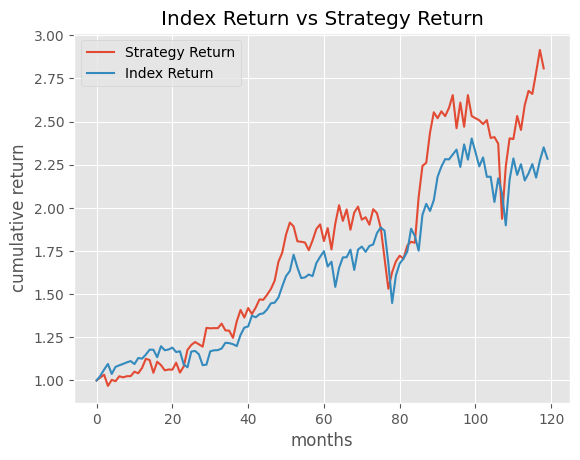

In [88]:
#visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+DJI["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])

# Strategy 2: Resistance Breakout

**About Strategy:**

Resistance breakout is a well-known strategy where we see the price of the stock breaching a previous resistance level.

Our breakout rule in this case will be a price breaching 20 period rolling max/min price used
in conjunction with a volume breaching rolling maximum volume. 

Using this, we go long/short stocks based on the signal.

Additionally, we define exit/stop loss signal with a previous price plus/minus 20 period ATR as the rolling stop loss price.

Finally, we backtest the strategy and calculate the cumulative return for each stock.

In [89]:
import numpy as np
import pandas as pd
import copy

def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    
    # Calculating High - Low value of current row
    df['H-L']=abs(df['High']-df['Low'])
    
    # Calculating High value of current row - Adjusted Close of previous row
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    
    # Calculating Low value of current row - Adjusted Close of previous row
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    
    # Taking the max of the previous 3 values and making it True Range
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    
    # Calculates Average True Range
    df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    
    # Drop the rest of the columns
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    
    
    return df2['ATR']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    
    # Calculating cumulative product return 
    df["cum_return"] = (1 + df["ret"]).cumprod()
    
    # There are 78,5-minute candle in a day and 252 days in a year
    n = len(df)/(252*78)
    
    # Calculate CAGR according to formula 
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    
    # Calculating volatility, the standard deviation of returns. This is annualized.
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [90]:
tickers = ["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]
# ["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","TSLA","AMD"]

ohlc_intraday = {} # directory with ohlc value for each stock   

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_intraday[ticker] = yf.download(ticker,period="1mo",interval='5m')
    ohlc_intraday[ticker].dropna(inplace=True,how="all")

tickers = ohlc_intraday.keys()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [91]:
################################   Backtesting    ####################################

# calculating ATR and rolling max price for each stock and consolidating this info by stock in a separate dataframe

# OHLC dict is a deep copy of OHLC intraday to preserve orignal data and save time in running code again in case something wrong happens
ohlc_dict = copy.deepcopy(ohlc_intraday)

# Tickers_signal dictionary will have format like this: tickers_signal = {"MSFT":"buy", "AAPL":"", "INTC": "sell"}
tickers_signal = {}

# All KPIs work only when you have return as a seperate column
tickers_ret = {} 

for ticker in tickers:
    print("calculating ATR and rolling max price for ",ticker)
    # Calculating technical indicators
    ohlc_dict[ticker]["ATR"] = ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"] = ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"] = ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"] = ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    
    # Initially, there is no signal for those tickers
    tickers_signal[ticker] = ""
    
    # Creating a list to store ticker return
    tickers_ret[ticker] = [0]


calculating ATR and rolling max price for  MSFT
calculating ATR and rolling max price for  AAPL
calculating ATR and rolling max price for  META
calculating ATR and rolling max price for  AMZN
calculating ATR and rolling max price for  INTC
calculating ATR and rolling max price for  CSCO
calculating ATR and rolling max price for  VZ
calculating ATR and rolling max price for  IBM
calculating ATR and rolling max price for  QCOM
calculating ATR and rolling max price for  LYFT


In [92]:
# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    print("calculating returns for ",ticker)
    
    # Iterating over every single row of the dataframe for a particular ticker
    for i in range(1,len(ohlc_dict[ticker])):
        
        # This code block is concerning with assigning what is the signal
        # and updating the signal for that particular row
        
        if tickers_signal[ticker] == "":
            # No return if there is no signal/trade (for first row)
            tickers_ret[ticker].append(0)
            
            # Now, checking if for that particular candle, a new signal is created
            
            # Breakout happens when High touches rolling max price (is equal to) or is greater
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                #Need to use [i-1] here because if there is breakout, volume at i will be same as rolling max volume at i
                #Therefore, the below condition will never get satisfied
                tickers_signal[ticker] = "Buy"
                
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                
        # This checks for a Buy signal
        elif tickers_signal[ticker] == "Buy":
            # Scenario  1: Stop loss criteria is met
            # If the Close price - previous ATR was breached, then change buy signal to no signal and close off the position
            # Here, we are revising stop loss level after every trade
            if ohlc_dict[ticker]["Low"][i]<ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                # Calculate the return of the trade
                # Assumption: You can fill your trade at stop loss point (Close price - ATR)
                # Take exit price divide by previous periods close price and you get the return for that particular candle
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
                
            # Scenario 2: Stop loss doesn't get triggered but reversal gets triggered
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
            
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
                
        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["High"][i]>ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
     
    # For each of these list, we convert them to numpy array and add them as new column to our dataframe
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])


calculating returns for  MSFT
calculating returns for  AAPL
calculating returns for  META
calculating returns for  AMZN
calculating returns for  INTC
calculating returns for  CSCO
calculating returns for  VZ
calculating returns for  IBM
calculating returns for  QCOM
calculating returns for  LYFT


calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  META
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM
calculating KPIs for  QCOM
calculating KPIs for  LYFT


,Return,Sharpe Ratio,Max Drawdown
MSFT,-0.08587364,-2.01432113,0.01872275
AAPL,0.01265199,-0.21078001,0.01619438
META,0.35693436,2.87887629,0.01665424
AMZN,0.06582622,0.38995393,0.03039664
INTC,0.55369582,5.01713034,0.01189986
CSCO,0.19365421,2.50678992,0.01122250
VZ,0.01390152,-0.31453958,0.00846179
IBM,-0.01035512,-1.18993749,0.00597456
QCOM,-0.21900323,-3.20417407,0.02392407
LYFT,-0.32827041,-2.78330895,0.05290697


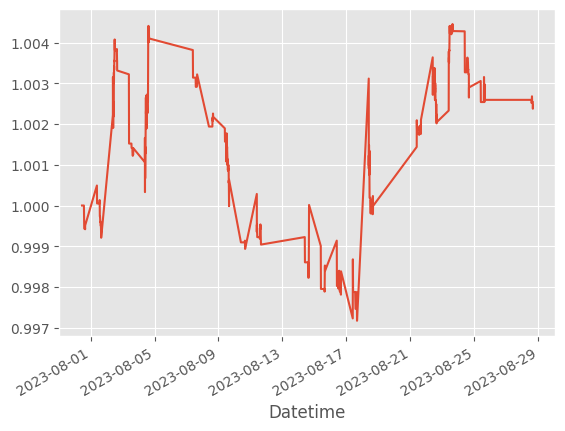

In [93]:
# calculating overall strategy's KPIs
strategy_df = pd.DataFrame()

# appending return of tickers to strategy dataframe
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]

# As trader, you have certain amount of capital and you allocate equal capital to each of the trade
# And only when you get the signal, you allocate $X to the stock. Rest stay unallocated.

# Because capital is allocated equally, mean of these returns are taken. 
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)
sharpe(strategy_df,0.025)
max_dd(strategy_df)

# vizualization of strategy return
(1+strategy_df["ret"]).cumprod().plot()

#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

# Strategy 3 - Renko & OBV

**About Strategy:**

In this strategy, we use a combination of Renko charts and OBV indicator.

Our buy signal has the following conditions:
1) Renko bar >= 2
2) 5 day OBV slope > 30 degrees
3) Exit if Renko bar < 2

Our sell signal has the following conditions:
1) Renko bar <= -2
2) 5 day OBV slope < -30 degrees
3) Exit if Renko bar > -2

In [94]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    "ser is the OBV dataframe"
    
    # initializing a list of slopes
    slopes = [i*0 for i in range(n-1)]
    
    # calculating for loop from n till end of ser
    for i in range(n,len(ser)+1):
        # rolling window of n values
        y = ser[i-n:i]
        
        # x can be anything as its time series
        x = np.array(range(n))
        
        # scaling y and x so it better fits our OLS
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        
        # Adding constant "+ c" to make it y = mx + c form
        x_scaled = sm.add_constant(x_scaled)
        
        # Using OLS regression
        model = sm.OLS(y_scaled,x_scaled)
        
        # fitting model
        results = model.fit()
        
        # appending the slope to the last place in list
        slopes.append(results.params[-1])
        
    # Calculating slope angle
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    
    # Annotating columns with +1 and -1
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    
    # Calculating the number of bars of the renko chart so far (if previous number is positive, add. If previous number is negative, subtract)
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    
    # Removes all duplicate row values and keeping the last row value
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Adj Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    
def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [95]:
tickers = ["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]

ohlc_intraday = {} # directory with ohlc value for each stock   

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_intraday[ticker] = yf.download(ticker,period="1mo",interval='5m')
    ohlc_intraday[ticker].dropna(inplace=True,how="all")

tickers = ohlc_intraday.keys()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [96]:
################################Backtesting####################################

# Merging renko df with original ohlc df
ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}

for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
    # New column date which is the index 
    df[ticker]["Date"] = df[ticker].index
    # Perform outer merge on date column. Just merging bar_num and date as rest are same.
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
    # forward filling NaN values
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["obv"]= OBV(ohlc_renko[ticker])
    ohlc_renko[ticker]["obv_slope"]= slope(ohlc_renko[ticker]["obv"],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

       
#Identifying signals and calculating daily return
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i]/ohlc_renko[ticker]["Adj Close"][i-1])-1)
            if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30:
                tickers_signal[ticker] = "Sell"
            elif ohlc_renko[ticker]["bar_num"][i]<2:
                tickers_signal[ticker] = ""
                
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1]/ohlc_renko[ticker]["Adj Close"][i])-1)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]>-2:
                tickers_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])

merging for  MSFT
merging for  AAPL
merging for  META
merging for  AMZN
merging for  INTC
merging for  CSCO
merging for  VZ
merging for  IBM
merging for  QCOM
merging for  LYFT
calculating daily returns for  MSFT
calculating daily returns for  AAPL
calculating daily returns for  META
calculating daily returns for  AMZN
calculating daily returns for  INTC
calculating daily returns for  CSCO
calculating daily returns for  VZ
calculating daily returns for  IBM
calculating daily returns for  QCOM
calculating daily returns for  LYFT


In [97]:
#calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)
sharpe(strategy_df,0.025)
max_dd(strategy_df)  

0.05072357875200454

<Axes: >

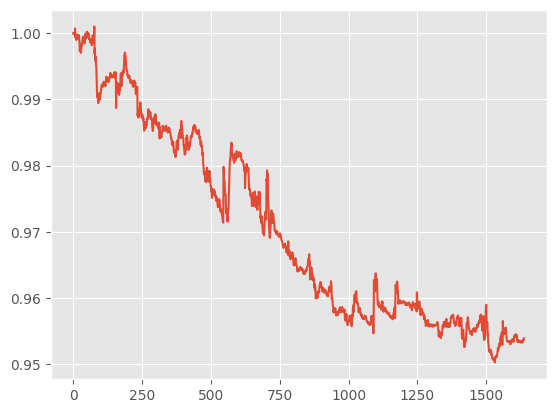

In [98]:
#visualizing strategy returns
(1+strategy_df["ret"]).cumprod().plot()

In [99]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])


calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  META
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM
calculating KPIs for  QCOM
calculating KPIs for  LYFT


In [100]:
KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

,Return,Sharpe Ratio,Max Drawdown
MSFT,-0.42020276,-2.68196751,0.05889822
AAPL,0.60378886,3.75112763,0.03638901
META,0.66127510,2.41915601,0.06776137
AMZN,-0.72248894,-3.31500388,0.12671654
INTC,-0.81251955,-4.26006531,0.14914567
CSCO,0.47245264,2.68764948,0.03407101
VZ,-0.52853827,-5.88396641,0.06431310
IBM,-0.40999364,-3.72471131,0.04696380
QCOM,0.44563053,1.91146785,0.04708704
LYFT,-0.94464127,-1.67591224,0.24417212


# Strategy 4 - Renko & MACD

If value of MACD is greater than value of signal line

and short-term slope of MACD is greater than slope of signal line

**About Strategy:**

In this strategy, we will use a combination of Renko charts and the MACD indicator.

Our buy signal has the following conditions:
1) Renko bar >= 2
2) MACD line is above signal line
3) MACD line's slope > signal line's slope (calculated over last 5 periods)
4) Exit when MACD line < signal line AND MACD line slope < signal line's slope

Our sell signal has the following conditions:
1) Renko bar <= -2
2) MACD line is below signal line
3) MACD line's slope < signal line's slope (over last 5 periods)
4) We exit when MACD line is above signal line AND MACD line's slope is greater than signal line's slope

In [101]:
def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["Adj Close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["Adj Close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    return (df["MACD"],df["Signal"])

def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df


def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    
def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [102]:
tickers = ["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]

ohlc_intraday = {} # directory with ohlc value for each stock   

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_intraday[ticker] = yf.download(ticker,period="1mo",interval='5m')
    ohlc_intraday[ticker].dropna(inplace=True,how="all")

tickers = ohlc_intraday.keys()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [103]:
################################Backtesting####################################

#Merging renko df with original ohlc df
ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
    df[ticker]["Date"] = df[ticker].index
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["macd"]= MACD(ohlc_renko[ticker],12,26,9)[0]
    ohlc_renko[ticker]["macd_sig"]= MACD(ohlc_renko[ticker],12,26,9)[1]
    ohlc_renko[ticker]["macd_slope"] = slope(ohlc_renko[ticker]["macd"],5)
    ohlc_renko[ticker]["macd_sig_slope"] = slope(ohlc_renko[ticker]["macd_sig"],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []
    
#Identifying signals and calculating daily return
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i]/ohlc_renko[ticker]["Adj Close"][i-1])-1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Sell"
                    
                # Not taking renko into account for exit criteria
                elif ohlc_renko[ticker]["macd"][i]<ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]<ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = ""
        
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1]/ohlc_renko[ticker]["Adj Close"][i])-1)
            if i > 0:
                if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = "Buy"
                elif ohlc_renko[ticker]["macd"][i]>ohlc_renko[ticker]["macd_sig"][i] and ohlc_renko[ticker]["macd_slope"][i]>ohlc_renko[ticker]["macd_sig_slope"][i]:
                    tickers_signal[ticker] = ""
    
    # Converting dictionary into dataframe
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])

merging for  MSFT
merging for  AAPL
merging for  META
merging for  AMZN
merging for  INTC
merging for  CSCO
merging for  VZ
merging for  IBM
merging for  QCOM
merging for  LYFT
calculating daily returns for  MSFT
calculating daily returns for  AAPL
calculating daily returns for  META
calculating daily returns for  AMZN
calculating daily returns for  INTC
calculating daily returns for  CSCO
calculating daily returns for  VZ
calculating daily returns for  IBM
calculating daily returns for  QCOM
calculating daily returns for  LYFT


In [104]:
#calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)
sharpe(strategy_df,0.025)
max_dd(strategy_df)  

0.036074029265675246

<Axes: >

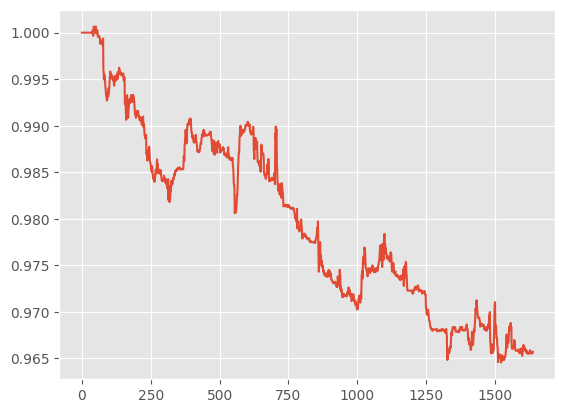

In [105]:
#visualizing strategy returns
(1+strategy_df["ret"]).cumprod().plot()

In [106]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  META
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM
calculating KPIs for  QCOM
calculating KPIs for  LYFT


,Return,Sharpe Ratio,Max Drawdown
MSFT,0.14692279,0.99251474,0.02455901
AAPL,0.15301232,1.17156616,0.02077986
META,0.65594847,3.04701894,0.04961764
AMZN,-0.48590661,-3.28327104,0.06404871
INTC,-0.44588023,-3.73037444,0.05897223
CSCO,-0.07120919,-0.78506191,0.04818279
VZ,-0.26098133,-4.21712046,0.02861246
IBM,-0.19487650,-2.72278645,0.03203277
QCOM,-0.22538258,-1.57088889,0.04726246
LYFT,-0.94973622,-2.71947135,0.24011992
